In [39]:
import torch
import torchmetrics
import torch.nn.functional as F
from torch import nn
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys, numpy as np
from keras.datasets import mnist
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Getting the MNIST Data Ready for Training

This code prepares the MNIST handwritten digit dataset for training a neural network. Here's what's happening in three simple steps:

1. **Load and prepare the data:**
    * Loads the first 60,000 images and labels from the training set.
    * Reshapes the images into a format suitable for the model (28x28 pixels per image).
    * Converts the data to PyTorch tensors for efficient computations.

2. **Encode the labels:**
    * Converts the digit labels (e.g., 3) into one-hot encoded vectors (e.g., [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]). This helps the model understand the categories better.

3. **Split data into training and testing sets:**
    * Splits the data into two parts: 80% for training the model and 20% for testing its performance.


In [40]:
# Preparing the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
images, labels = (x_train[0:60000].reshape(60000,28*28) / 255, y_train[0:60000])
N_classes = 10
# Converting the Data to tensors
X_tensor = torch.from_numpy(images).type(torch.float).to(device=device)
y_tensor = torch.from_numpy(labels).type(torch.LongTensor).to(device=device)
y_tensor = F.one_hot(y_tensor, N_classes)
y_tensor = y_tensor.argmax(dim=1)
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, train_size=0.8, random_state=42)
print(f"Train images shape is {X_train.shape}, | Train labels shape is {y_train.shape}")
print(f"Test images shape is {X_test.shape}, | Test labels shape is {y_test.shape}")

Train images shape is torch.Size([48000, 784]), | Train labels shape is torch.Size([48000])
Test images shape is torch.Size([12000, 784]), | Test labels shape is torch.Size([12000])


## Helper Functions

**This below function checks how often a model's predictions match the true answers.**

- It takes two lists of answers: the model's guesses (`y_pred`) and the correct answers (`y_true`).
- It counts how many times the guesses are correct.
- It divides that number by the total number of answers to get the percentage of correct answers (accuracy).
- It returns that percentage as the final result.


In [41]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_true)) * 100
    return acc
# metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
# precision = torchmetrics.Precision(task="multiclass", num_classes=10).to(device)
# f1_score = torchmetrics.F1Score(task="multiclass", num_classes=10).to(device)

# Model Initialization

**This code defines and sets up a simple neural network for MNIST digit classification.**

- It creates a class called `FullyConnectedNuralNetwork` with 2 hidden layers, each with 100 neurons.
- Each hidden layer uses a ReLU activation function and a 20% dropout layer to help prevent overfitting.
- The output layer has 10 neurons, representing the 10 possible digits (0-9).
- An instance of this network is created and moved to a specific device (like a GPU for faster training).
- Finally, a summary of the network's structure and parameters is printed.

In [42]:
class FullyConnectedNuralNetwork(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers):
        super().__init__()
        self.layer_block = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_layers, out_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=hidden_layers, out_features=out_features)
        )
    def forward(self, x):
        return self.layer_block(x)
model = FullyConnectedNuralNetwork(784,10,100)
model = model.to(device)
summary(model, input_size=X_train.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1           [-1, 48000, 100]          78,500
              ReLU-2           [-1, 48000, 100]               0
           Dropout-3           [-1, 48000, 100]               0
            Linear-4           [-1, 48000, 100]          10,100
              ReLU-5           [-1, 48000, 100]               0
           Dropout-6           [-1, 48000, 100]               0
            Linear-7            [-1, 48000, 10]           1,010
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 143.55
Forward/backward pass size (MB): 223.39
Params size (MB): 0.34
Estimated Total Size (MB): 367.29
----------------------------------------------------------------


# Loss Function and optimizer initialization

**1. Setting the Loss Function:**

- `loss_fn = nn.CrossEntropyLoss()` is used to measure how well the model's predictions match the true labels.
- It's specifically designed for classification tasks like predicting handwritten digits in this case.

**2. Choosing the Optimizer:**

- `optimizer = torch.optim.Adam(model.parameters(), lr=0.01)` is responsible for updating the model's parameters (weights and biases) to improve its predictions.
- It uses the Adam algorithm, known for its efficiency and effectiveness in many deep learning scenarios.
- `lr=0.01` sets the learning rate, which controls how large each update to the parameters is.


In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)

# Training and Testing Loop

**Initialization:**

- **epochs:** Defines the number of training iterations over the entire dataset.
- **Lists:** `epochs_values`, `train_loss_values`, and `test_loss_values` store training details for visualization later.

**Training Loop:**

- **`for epoch in range(epochs):`:** Iterates through the specified number of epochs.
- **`model.train()`:** Sets the model to training mode (enables dropout and other training-specific layers).
- **`y_logits = model(X_train)`:** Feeds the training data (`X_train`) to the model, obtaining logits (pre-softmax outputs).
- **`y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)`:**
    - Applies softmax activation to convert logits into probabilities for each class.
    - Uses `argmax` to obtain the predicted class index for each sample.
- **`acc_train = accuracy(y_preds, y_train)`:** Calculates the training accuracy using your defined `accuracy` function.
- **`training_loss = loss_fn(y_logits, y_train)`:** Calculates the training loss using the CrossEntropy loss function and true labels.
- **`epochs_values.append(epoch)`, etc.:** Appends current epoch, training loss, and test loss to their respective lists for later visualization.
- **`optimizer.zero_grad()`:** Empties the optimizer's gradient accumulator before backpropagation.
- **`training_loss.backward()`:** Backpropagates the loss through the network to calculate gradients for each parameter.
- **`optimizer.step()`:** Updates the model's parameters based on the calculated gradients and learning rate.
- **`model.eval()`:** Sets the model to evaluation mode (disables dropout for more stable predictions).

**Testing Part:**

- **`with torch.inference_mode():`:** Disables gradient computation for efficiency during testing.
- **Similar steps for testing:** Performs prediction and loss calculation on the test set.
- **`if epoch % 9 ==0:`:** Prints training and testing information every 9 epochs for progress monitoring.

In [44]:
epochs = 120
epochs_values = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1) # dim 1 to apply the soft max and argmax on the rows
    acc_train = accuracy(y_preds, y_train)
    training_loss = loss_fn(y_logits, y_train)
    epochs_values.append(epoch)
    train_loss_values.append(training_loss)
    optimizer.zero_grad()
    training_loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
        y_test_logits = model(X_test)
        y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)
        acc_test = accuracy(y_test_preds, y_test)
        testing_loss = loss_fn(y_test_logits, y_test)
        test_loss_values.append(testing_loss)
    if epoch % 9 ==0:
        print(f'Epoch {epoch+1} | Training Loss: {training_loss} - Training Accuracy {acc_train} | Testing Loss: {testing_loss} - Testing Accuracy {acc_test}')


Epoch 1 | Training Loss: 2.3081324100494385 - Training Accuracy 7.475 | Testing Loss: 2.168668031692505 - Testing Accuracy 42.541666666666664
Epoch 10 | Training Loss: 0.6024064421653748 - Training Accuracy 81.01041666666666 | Testing Loss: 0.4658886790275574 - Testing Accuracy 86.41666666666666
Epoch 19 | Training Loss: 0.368225634098053 - Training Accuracy 88.94999999999999 | Testing Loss: 0.2935028076171875 - Testing Accuracy 91.19166666666668
Epoch 28 | Training Loss: 0.2794199287891388 - Training Accuracy 91.52916666666667 | Testing Loss: 0.2248843014240265 - Testing Accuracy 93.18333333333332
Epoch 37 | Training Loss: 0.22463403642177582 - Training Accuracy 93.325 | Testing Loss: 0.18054628372192383 - Testing Accuracy 94.625
Epoch 46 | Training Loss: 0.1842150092124939 - Training Accuracy 94.45833333333333 | Testing Loss: 0.15196244418621063 - Testing Accuracy 95.36666666666666
Epoch 55 | Training Loss: 0.15793362259864807 - Training Accuracy 95.21041666666666 | Testing Loss: 0.1

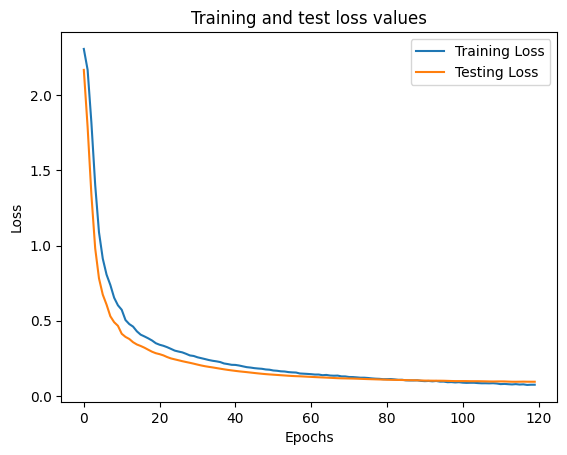

In [45]:
plt.plot(epochs_values, torch.tensor(train_loss_values).numpy(), label='Training Loss')
plt.plot(epochs_values, torch.tensor(test_loss_values).numpy(), label='Testing Loss')
plt.title('Training and test loss values')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();